### Backends

You can change the backend to perform computation with a different framework. By default, the backend is JAX, but you can also perform the computation using PyTorch or set up your own backend, if you need. For instance, after setting the backend to PyTorch, all the computation is done by PyTorch. It doesn't matter, which backend you are using: the interface remains the same.

Let us give some examples:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,8)

from tucker_riemopt import backend as back
from tucker_riemopt import set_backend

First of all let's try default (JAX) backend:

In [2]:
A = back.tensor(np.random.rand(3, 3))
print(type(A)) # jax DeviceArray
print(back.svd(A, full_matrices=False)[1])
# we can cast tensor to numpy array from any backend at any time
Q = back.qr(A)[0]
Q = back.to_numpy(Q)
print(np.allclose(np.eye(3), Q.T @ Q))

<class 'jaxlib.xla_extension.DeviceArray'>
[1.3000957  0.6547875  0.08933832]
False


And now let's switch to PyTorch

In [3]:
set_backend("pytorch")
# and now we will do all the same operations
A = back.randn((3, 3)) # we don't actually need numpy here
print(type(A)) # pytorch tensor
print(back.svd(A, full_matrices=False)[1])
# we can cast tensor to numpy array from any backend at any time
Q = back.qr(A)[0]
Q = back.to_numpy(Q)
print(np.allclose(np.eye(3), Q.T @ Q))

<class 'torch.Tensor'>
tensor([1.9576, 1.3520, 0.1724], dtype=torch.float64)
True


#### Autodiff

Now we are calculating Riemann gradient using JAX and PyTorch backends.
Let us prepare some code for demostration.

In [4]:
from tucker_riemopt.tucker import Tucker
from tucker_riemopt.riemopt import compute_gradient_projection

def f(T: Tucker):
    A = T.full()
    return (A ** 2 - A).sum()

random_seed = 42
np.random.seed(random_seed)

def calculate_grads(n):
    set_backend("jax")
    A = np.random.randn(n, n, n)
    A_jax = back.tensor(A)
    T_jax = Tucker.full2tuck(A_jax)
    grad_jax = compute_gradient_projection(f, T_jax)
    grad_jax = back.to_numpy(grad_jax.full())
    set_backend("pytorch")
    A_torch = back.tensor(A)
    T_torch = Tucker.full2tuck(A_torch)
    grad_torch = compute_gradient_projection(f, T_torch)
    grad_torch = back.to_numpy(grad_torch.full())
    return grad_jax, grad_torch

And now let's explore difference between jax grad and torch grad:

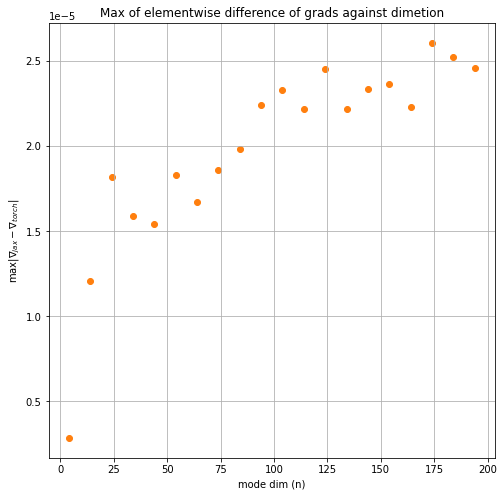

In [5]:
Ns = np.arange(4, 201, 10)
plt.xlabel("mode dim (n)")
plt.ylabel(r"$\max|\nabla_{jax} - \nabla_{torch}|$")
plt.title("Max of elementwise difference of grads against dimetion")
for n in Ns:
    grad_jax, grad_torch = calculate_grads(n)
    plt.scatter(n, np.abs(grad_jax - grad_torch).max(), c="tab:orange")
plt.grid()
plt.show()

We may note that absolute elementwise error remains small. 